<a href="https://colab.research.google.com/github/ld-minh4354/Impact-of-AI-on-Environmental-Quality/blob/main/Impact_of_AI_on_Environmental_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-ups

In [117]:
# Importing relevant Python packages
import sympy as sym
from scipy.optimize import fsolve, bisect
import matplotlib.pyplot as plt
import numpy as np

In [118]:
# Simulation constants
period_length = 2
num_period = 100

# Economy constants
sigma = 10
alpha = 1/3
psi = alpha ** 2
phi = (1 - alpha) * (1 - sigma)
Y_c0 = 307.77
Y_d0 = 1893.25

# Calculating A_c0 and A_d0
r = (Y_c0 / Y_d0) ** (1 / (alpha + phi -1))
A_c0 = (alpha ** 2 / psi) ** (alpha / (1-alpha)) * (1 + r ** (-phi)) ** (-(alpha + phi) / phi) * Y_c0
A_d0 = r * A_c0

# Innovation constants
gamma = 1
eta_c = eta_d = 0.02 * period_length

# Environment constants
temp_disaster = 6
emission_0 = 17.48251782
S_bar = 280 * (2 ** (temp_disaster / 3) - 1)
S_0 = S_bar - 99
delta = 0.5 * emission_0 / S_0
xi = emission_0 / Y_d0
CO2_disaster = 1120

# Constants (and research info) to find k
author_list = ["Acemoglu (2024)", "Goldman Sachs (2023)", "McKinsey & Company (2023)", "Korinek & Suh (2024)"]
gdp_effect_list = [0.9, 7, 33.2, 64.4]
x0_search = [0.1, 0.1, 0.18025, 0.2]

# Simulation Helper Code

In [119]:
class SimulationHelper:
    def __init__(self):
        pass

    # This calculates the ratio of expected profit for researchers in the new and old sectors. See Theorem 1.
    def scientist_allocation_equilibrium(self, s_c, A_c, A_d, t, k):
        I_ct = np.e ** (3 * k * t)
        I_dt = np.e ** (k * t)

        func = (eta_c / eta_d) \
            * (1 + gamma * I_ct) / (1 + gamma * I_dt) \
            * ((1 + gamma * eta_c * I_ct * s_c) / (1 + gamma * eta_d * I_dt * (1 - s_c))) ** (-phi - 1) \
            * (A_c / A_d) ** (-phi)

        return func

    # This simulates the equilibrium process and determine the values of variables at equilibrium
    def equilibrium(self, k, num_period, test = False):
        # Initialise arrays of different variables, some of which have starting values at t=0
        A_c = [A_c0]
        A_d = [A_d0]
        s_c = []
        Y_ratio = []
        Y_d = []
        C = []
        S = [S_0]
        temp = []

        overflow = False

        for t in range(1, num_period + 1):
            if overflow:
                s_c.append(s_c[-1])
                A_c.append(A_c[-1])
                A_d.append(A_d[-1])
                Y_d.append(Y_d[-1])
                Y_ratio.append(Y_ratio[-1])
                C.append(C[-1])
                S.append(S[-1])
                temp.append(temp[-1])
            if not overflow:
                # Solving for equilibrium scientist allocation
                if self.scientist_allocation_equilibrium(1, A_c[t-1], A_d[t-1], t, k) >= 1:
                    s_ct = 1
                elif self.scientist_allocation_equilibrium(0, A_c[t-1], A_d[t-1], t, k) <= 1:
                    s_ct = 0
                else:
                    equation = lambda s_ct: self.scientist_allocation_equilibrium(s_ct, A_c[t-1], A_d[t-1], t, k) - 1
                    s_ct = bisect(equation, 0, 1)

                # Determining the value of I_jt
                I_ct = np.e ** (3 * k * t)
                I_dt = np.e ** (k * t)

                # Calculating values of relevant variables at time t
                A_ct = (1 + gamma * eta_c * I_ct * s_ct) * A_c[-1]
                A_dt = (1 + gamma * eta_d * I_dt * (1 - s_ct)) * A_d[-1]

                Y_ct = (alpha ** 2 / psi) ** (alpha / (1-alpha)) * (1 / (A_ct ** phi + A_dt ** phi) ** ((alpha + phi) / phi)) * A_ct * A_dt ** (alpha + phi)
                Y_dt = (alpha ** 2 / psi) ** (alpha / (1-alpha)) * (1 / (A_ct ** phi + A_dt ** phi) ** ((alpha + phi) / phi)) * A_ct ** (alpha + phi) * A_dt
                Y_ratio_t = Y_ct / (Y_ct + max(Y_dt, 0.0000001))

                C_t = (alpha ** 2 / psi) ** (alpha / (1-alpha)) * (1 - alpha ** 2) * (A_ct ** phi + A_dt ** phi) ** (-1 / phi) * A_ct * A_dt

                S_t = min(max(-xi * Y_dt + (1 + delta) * S[-1], 0.00001), S_bar)
                temp_t = 3 * np.log2((CO2_disaster - S_t) / 280)

                # Append these values to their arrays
                s_c.append(s_ct)
                A_c.append(A_ct)
                A_d.append(A_dt)
                Y_d.append(Y_dt)
                Y_ratio.append(Y_ratio_t)
                C.append(C_t)
                S.append(S_t)
                temp.append(temp_t)

                # Check overflow
                if C_t > 10 ** 100:
                    overflow = True


        if test:
            return C[-1]

        # Return dictionary containing the arrays, with elements at t=0 removed
        return {'A_c': A_c[1:], 'A_d': A_d[1:], 's_c': s_c, 'Y_d': Y_d, 'Y_ratio': Y_ratio, 'C': C, 'S': S, 'temp': temp}

# Initialise simulation object
simulation_helper = SimulationHelper()

# Finding Values of k

In [120]:
class FindK:
    def __init__(self):
        self.C_original = simulation_helper.equilibrium(0, 5, test = True)

    def set_gdp_effect(self, gdp_effect):
        self.gdp_effect = gdp_effect

    def equation(self, k):
        return simulation_helper.equilibrium(k, 5, test = True) - (1 + self.gdp_effect / 100) * self.C_original

    def find_k(self):
        k_list = []
        gdp_effect_recheck_list = []

        for i in range(4):
            findk.set_gdp_effect(gdp_effect_list[i])
            k_list.append(fsolve(findk.equation, x0 = x0_search[i])[0])
            gdp_effect_recheck_list.append(findk.equation(k_list[-1]))

        return k_list, gdp_effect_recheck_list

In [141]:
x0_search = [0.1, 0.1, 0.18025, 0.2]
findk = FindK()
k_list, gdp_effect_recheck_list = findk.find_k()

print(f"List of values of k: {k_list}")
print(f"Error in GDP effect: {gdp_effect_recheck_list}")

List of values of k: [0.015978353375114593, 0.10205734953937123, 0.18033252768751246, 0.20127413184293383]
Error in GDP effect: [-4.263256414560601e-14, 2.842170943040401e-14, 2.648912060040473, 1.7053025658242404e-13]


<ipython-input-120-5b8dd6277a37>:17: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  k_list.append(fsolve(findk.equation, x0 = x0_search[i])[0])


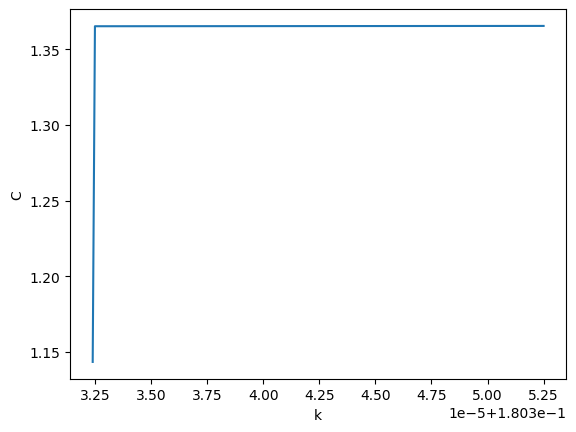

In [154]:
k_values = []
C_values = []

for i in range(1803324, 1803526):
    k_values.append(i/10000000);
    C_values.append(simulation_helper.equilibrium(i/10000000, 5, test = True) / simulation_helper.equilibrium(0, 5, test = True))

plt.plot(k_values, C_values)
plt.xlabel('k')
plt.ylabel('C')
plt.show()


# Running Simulation and Plotting

<ipython-input-119-1a5640f59b7e>:10: RuntimeWarning: overflow encountered in scalar multiply
  func = (eta_c / eta_d) \
<ipython-input-119-1a5640f59b7e>:13: RuntimeWarning: overflow encountered in scalar power
  * (A_c / A_d) ** (-phi)


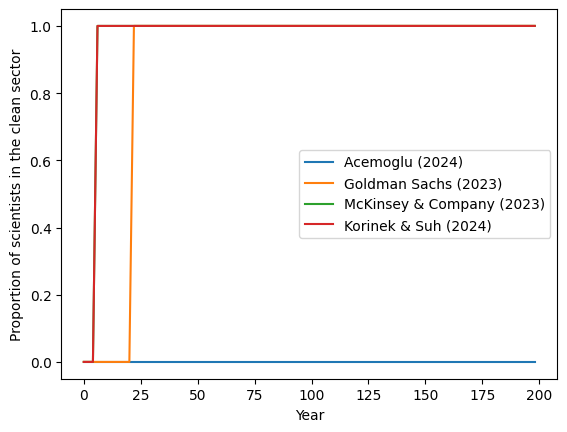

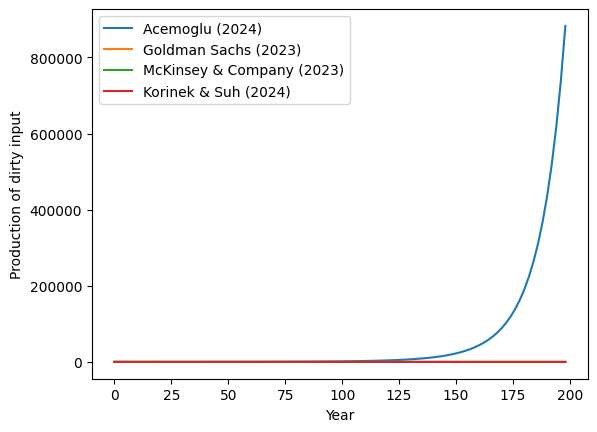

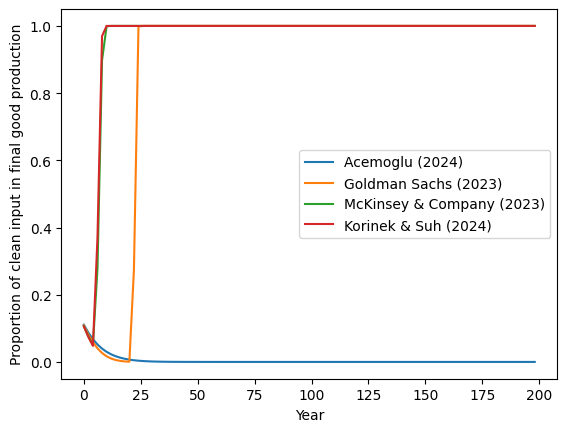

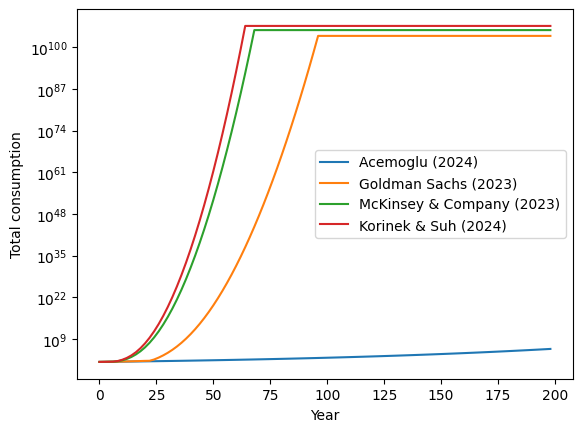

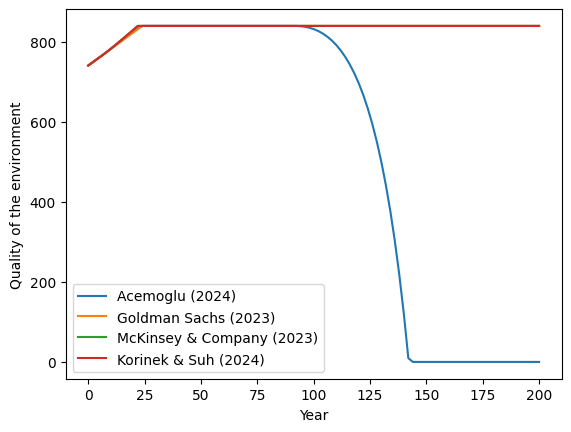

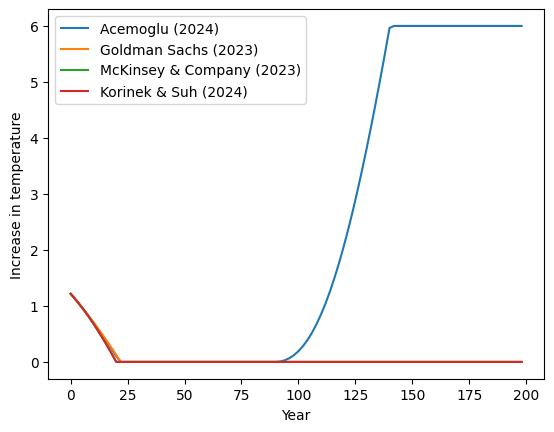

In [157]:
class SimulationPlotting:
    def __init__(self):
        self.variable_description = {"s_c": "Proportion of scientists in the clean sector",
                                     "Y_d": "Production of dirty input",
                                     "Y_ratio": "Proportion of clean input in final good production",
                                     "C": "Total consumption",
                                     "S": "Quality of the environment",
                                     "temp": "Increase in temperature"}

        self.log_scale_dict = {"s_c": False,
                               "Y_d": False,
                               "Y_ratio": False,
                               "C": True,
                               "S": False,
                               "temp": False}

    def simulation(self):
        self.simulation_result = []
        for k in k_list:
            self.simulation_result.append(simulation_helper.equilibrium(k, num_period))

    def plotting(self):
        for variable, description in self.variable_description.items():
            self.plotting_each_variable(variable, description, self.log_scale_dict[variable])

    def plotting_each_variable(self, variable, description, log_scale):
        for i in range(4):
            plt.plot([2*x for x in range(len(self.simulation_result[i][variable]))], self.simulation_result[i][variable], label = author_list[i])

        if log_scale:
            plt.yscale('log')
        else:
            plt.yscale('linear')

        plt.xlabel('Year')
        plt.ylabel(description)

        plt.legend()
        plt.show()

simulationplotting = SimulationPlotting()
simulationplotting.simulation()
simulationplotting.plotting()

# Government Intervention Time Period

In [137]:
class GovtIntervention:
    def __init__(self):
        self.calculate_period()

    def min_T(self, k):
        a = (1 / (2*k)) * np.log((gamma * (np.e**(2*k) + np.e**k + 1) + 2) / (gamma * np.e**(2*k)))
        b = (1 / (3*k)) * np.log((np.e ** (-k/phi) - 1) / (gamma * eta_c)) - 1
        return a

    def calculate_period(self):
        for i in range(4):
            min_t = self.min_T(k_list[i]) * period_length
            print(f"{author_list[i]}: k = {k_list[i]}. Government intervention lasts {min_t} years.\n")

govt_intervention = GovtIntervention()

Acemoglu (2024): k = 0.015978353375114593. Government intervention lasts 99.33127473231372 years.

Goldman Sachs (2023): k = 0.10205734953937123. Government intervention lasts 14.403326393825024 years.

McKinsey & Company (2023): k = 0.1803324938024266. Government intervention lasts 7.584776087476761 years.

Korinek & Suh (2024): k = 0.20127413184293383. Government intervention lasts 6.663420607018747 years.

